In [1]:
import gym
import random
import torch
import numpy as np
from collections import namedtuple, deque
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.multiprocessing as mp
from torch.autograd import Variable
from torch.distributions import Categorical

In [10]:
env = gym.make('Pendulum-v0')
env.seed(2)

[2]

In [15]:
class DDPG_Agent():
    def __init__(self, state_dim, action_dim, hidden_dims, env, buffer_size, batch_size, seed=0):
        
        self.state_dim = state_dim
        self.action_dim = action_dim
        
        self.buffer_size = buffer_size
        self.batch_size = batch_size
        
        self.env = env
        
        self.actor = DDPG_Net(state_dim, action_dim, hidden_dims)
        self.critic = DDPG_Net(state_dim+action_dim, 1, hidden_dims)
        
        self.target_actor = DDPG_Net(state_dim, action_dim, hidden_dims)
        self.target_critic = DDPG_Net(state_dim+action_dim, 1, hidden_dims)
        
        self.actor_opt = torch.optim.Adam(self.actor.parameters(), lr=1e-3)
        self.critic_opt = torch.optim.Adam(self.critic.parameters(), lr=1e-3)
        
        self.target_actor_opt = torch.optim.Adam(self.target_actor.parameters(), lr=1e-3)
        self.target_critic_opt = torch.optim.Adam(self.target_critic.parameters(), lr=1e-3)
       
        self.memory = ReplayBuffer(buffer_size, batch_size, seed)
        self.noise = OrnsteinUhlenbeckProcess((action_dim,), .2)
        
        self.t_step = 0
        self.update_iter = 5
        self.target_network_mix = 5e-3
        
    def get_action(self, actor, state):
        return torch.tanh(actor(state))
    
    def get_q_value(self, critic, state, action):
        features = torch.cat([state, action], dim=1)
        return critic(features)
    
    def soft_update(self, target, src):
        for target_param, param in zip(target.parameters(), src.parameters()):
            target_param.detach_()
            target_param.copy_(target_param * (1.0 - self.target_network_mix) +
                               param * self.target_network_mix)    
    
    def learn(self, experiences, gamma=.99):
        states, actions, rewards, next_states, dones = experiences
        
        next_actions = self.get_action(self.target_actor, next_states)
        exp_q_values = self.get_q_value(self.target_critic, next_states, next_actions)
        exp_q_values = rewards + (gamma * exp_q_values * (1-dones))
        
        q_values = self.get_q_value(self.critic, states, actions)
        critic_loss = (q_values - exp_q_values).pow(2).mul(.5).sum(-1).mean()
        
        actions = self.get_action(self.actor, states)
        policy_loss = -(self.get_q_value(self.critic, states, actions).mean())
        
        self.actor_opt.zero_grad()
        policy_loss.backward()
        self.actor_opt.step()
        
        self.critic_opt.zero_grad()
        critic_loss.backward()
        self.critic_opt.step()
        
        self.soft_update(self.target_actor, self.actor)
        self.soft_update(self.target_critic, self.critic)
        
    def step(self):
        state = self.env.reset()
        score = 0
        
        while True:
            action = self.get_action(self.actor, torch.from_numpy(state).float())
            action = action.detach().numpy()
            action += self.noise.sample()
            action = np.clip(action, self.env.action_space.low, self.env.action_space.high)

            next_state, reward, done, _ = self.env.step(action)
            self.memory.add(state, action, reward, next_state, done)

            self.t_step = (self.t_step + 1) % self.update_iter
            if self.t_step == 0:
                if len(self.memory) > self.batch_size:
                    experiences = self.memory.sample()
                    self.learn(experiences, gamma=.99)

            state = next_state
            score += reward

            if done:
                break
                
        return score
    
class DDPG_Net(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dims):
        super(DDPG_Net, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.hidden_dims = hidden_dims
        
        assert(len(hidden_dims) >= 1)
        
        self.input_layer = nn.Linear(self.input_dim, self.hidden_dims[0])
        
        if len(self.hidden_dims) > 1:
            hidden_layers = []
            for i in range(len(hidden_dims)-1):
                hidden_layers.append(nn.Linear(self.hidden_dims[i], self.hidden_dims[i+1]))
            self.hidden_layers = nn.Sequential(*hidden_layers)

        self.output_layer = nn.Linear(self.hidden_dims[-1], self.output_dim)
        
    def forward(self, x):
        x = F.relu(self.input_layer(x))
        
        for hidden_layer in self.hidden_layers:
            x = F.relu(hidden_layer(x))
        
        output = self.output_layer(x)
        
        return output
    
class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.

        Params
        ======
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
            seed (int): random seed
        """
        self.memory = deque(maxlen=buffer_size)  
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
    
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float()#.to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).float()#.to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float()#.to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float()#.to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float()#.to(device)
  
        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)
    
class OrnsteinUhlenbeckProcess():
    def __init__(self, size, std, theta=.15, dt=1e-2, x0=None):
        self.theta = theta
        self.mu = 0
        self.std = std
        self.dt = dt
        self.x0 = x0
        self.size = size
        self.reset_states()

    def sample(self):
        x = self.x_prev + self.theta * (self.mu - self.x_prev) * self.dt + self.std * np.sqrt(self.dt) * np.random.randn(*self.size)
        self.x_prev = x
        return x

    def reset_states(self):
        self.x_prev = self.x0 if self.x0 is not None else np.zeros(self.size)

In [19]:
agent = DDPG_Agent(3, 1, [400, 300], env, int(1e5), 128)

In [20]:
scores = []
scores_window = deque(maxlen=100)
for i_epsiode in range(1, 2001):
    score = agent.step()
    scores_window.append(score)
    scores.append(score)
    
    print('\rEpisode %d: %.2f ± %.2f' % (i_epsiode, np.mean(scores_window), np.std(scores_window)), end="")
    if i_epsiode % 100 == 0:
        print('\rEpisode %d: %.2f ± %.2f' % (i_epsiode, np.mean(scores_window), np.std(scores_window)))

Episode 100: -1123.30 ± 334.42
Episode 200: -498.07 ± 313.052
Episode 300: -322.88 ± 225.04
Episode 400: -341.19 ± 245.45
Episode 500: -284.24 ± 209.57
Episode 600: -287.43 ± 211.43
Episode 700: -248.25 ± 189.32
Episode 800: -284.94 ± 208.28
Episode 900: -254.04 ± 169.69
Episode 1000: -275.33 ± 200.10
Episode 1100: -362.50 ± 270.89
Episode 1200: -277.63 ± 199.72
Episode 1300: -333.19 ± 253.45
Episode 1400: -299.02 ± 217.99
Episode 1500: -424.18 ± 300.03
Episode 1600: -427.86 ± 257.74
Episode 1700: -454.76 ± 261.53
Episode 1800: -412.27 ± 288.92
Episode 1900: -357.94 ± 251.24
Episode 2000: -474.79 ± 265.31


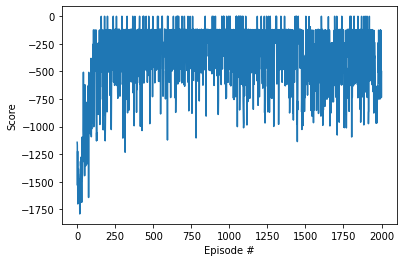

In [21]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()